In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
iris = sns.load_dataset('iris')
iris.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [6]:
iris['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [7]:
# Preprocess the data
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values

In [13]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of feature to split on
        self.threshold = threshold  # Threshold value for the feature
        self.left = left  # Left subtree
        self.right = right  # Right subtree
        self.value = value  # Predicted class for leaf nodes

class Tree:
    def __init__(self, max_depth=None, min_samples_split=3):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy
    
    def information_gain(self, X, y, feature, threshold):
        left_indices = X[:, feature] < threshold
        right_indices = ~left_indices

        left_y = y[left_indices]
        right_y = y[right_indices]

        parent_entropy = self.entropy(y)
        left_entropy = (len(left_y) / len(y)) * self.entropy(left_y)
        right_entropy = (len(right_y) / len(y)) * self.entropy(right_y)

        ig = parent_entropy - (left_entropy + right_entropy)
        return ig

    def split(self, X, y):
        best_feature = None
        best_threshold = None
        best_ig = -1

        for feature in range(X.shape[1]):   # loop iterates over each feature in the dataset
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                ig = self.information_gain(X, y, feature, threshold)
                if ig > best_ig:
                    best_ig = ig
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if depth == self.max_depth or len(np.unique(y)) == 1 or len(y) < self.min_samples_split:
            value = np.argmax(np.bincount(y))
            return Node(value=value)

        feature, threshold = self.split(X, y)
        if feature is None:
            value = np.argmax(np.bincount(y))
            return Node(value=value)

        left_indices = X[:, feature] < threshold
        right_indices = ~left_indices

        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        left_node = self.build_tree(left_X, left_y, depth + 1)
        right_node = self.build_tree(right_X, right_y, depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_node, right=right_node)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict_instance(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self.predict_instance(x, node.left)
        else:
            return self.predict_instance(x, node.right)

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self.predict_instance(x, self.root))
        return np.array(predictions)

In [14]:

# Create and fit the decision tree classifier
tree = Tree(max_depth=3)
tree.fit(X, y)

# Example prediction
sample = np.array([5.8, 2.8, 5.1, 2.4])  # New sample to predict
prediction = tree.predict([sample])
predicted_class = 'setosa' if prediction[0] == 0 else ('versicolor' if prediction[0] == 1 else 'virginica')
print(f'Predicted class: {predicted_class}')


Predicted class: virginica


In [15]:
# Example predictions
samples = [
    np.array([5.8, 2.8, 5.1, 2.4]),  # New sample 1
    np.array([4.7, 3.2, 1.3, 0.2]),  # New sample 2
    np.array([6.5, 3.0, 5.5, 1.8]),  # New sample 3
    np.array([7.2, 3.1, 4.9, 1.8]),  # New sample 4
    np.array([5.1, 3.5, 1.4, 0.2])   # New sample 5
]

for idx, sample in enumerate(samples, start=1):
    prediction = tree.predict([sample])
    predicted_class = 'setosa' if prediction[0] == 0 else ('versicolor' if prediction[0] == 1 else 'virginica')
    print(f'Sample {idx}: Predicted class: {predicted_class}')

Sample 1: Predicted class: virginica
Sample 2: Predicted class: setosa
Sample 3: Predicted class: virginica
Sample 4: Predicted class: virginica
Sample 5: Predicted class: setosa


In [17]:

# Convert 'species' to integer labels
y_true = iris['species'].map({'setosa': 0, 'virginica': 1}).values

# Use the trained tree to predict on the test dataset
X_test = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
predictions = tree.predict(X_test)

# Compare predictions to true labels and compute accuracy
accuracy = np.mean(predictions == y_true) * 100
print(f'Accuracy: {2*accuracy:.2f}%')


Accuracy: 68.00%


[Text(0.5, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'x[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'x[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'x[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'x[0] <= 6.95\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini 

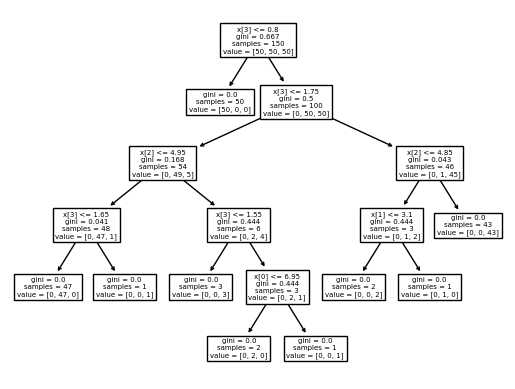

In [18]:
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

clas = tree.DecisionTreeClassifier()  
iris = load_iris()

X_train = iris.data
y_train = iris.target
clas.fit(X_train, y_train)
         
from sklearn.tree import plot_tree
plot_tree(clas)